<a href="https://colab.research.google.com/github/duyvm/funny_stuff_with_llm/blob/main/learning-rag/Langchain_build_a_qa_system_over_sql_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

- Install required packages
- Set environment variables
- Load model and vector db

In [ ]:
%pip install --quiet --upgrade langchain-community langgraph langchain[openai] langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.7 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = f"langchain-learning-rag"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Preview

- Guide: [Build a Question/Answering system over SQL data](https://python.langchain.com/docs/tutorials/sql_qa/)

- Use llm to generate SQL query and retrieve data from DB

- Based on retrieved data, generate anwser

### Download and build the database

- Guide here: [2 Sample Databases for SQLite](https://database.guide/2-sample-databases-sqlite/)

In [ ]:
!sudo apt-get install sqlite3
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 769 kB of archives.
After this operation, 1,873 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 sqlite3 amd64 3.37.2-2ubuntu0.4 [769 kB]
Fetched 769 kB in 0s (7,249 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package sqlite3.
(Reading d

In [ ]:
# load the database and testing
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print()
print(db.get_usable_table_names())
print()
print(db.run("SELECT * FROM Artist LIMIT 10;"))

sqlite

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [ ]:
# print(db.get_table_info())

### Chain approach

- Deterministic flow

- Can not distinguish between normal input "Hello" and query request from user

- Can not perform complex request require multiple queries

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

#### Convert question into SQL query

- Prepare the `system_message` parameters

- Leverage llm to generate SQL query from input question

In [ ]:
# create a prompt template

system_message = """
Given an input question, create a syntactically correct {dialect} query to run
to help find the answer. Unless the user specifies in his question a specific
number of examples they wish to obtain, always limit your query to at most {top_k}
results. You can order the results by a relevant column to return the most
interesting examples in database

Never query for all the columns from a specific table, only ask for the few relevant
columns given the question.

Pay attention to use only the column names that you can see in the schema description.
Be careful to not query for columns that do not exist. Also, pay attention to which
column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to run
to help find the answer. Unless the user specifies in his question a specific
number of examples they wish to obtain, always limit your query to at most {top_k}
results. You can order the results by a relevant column to return the most
interesting examples in database

Never query for all the columns from a specific table, only ask for the few relevant
columns given the question.

Pay attention to use only the column names that you can see in the schema description.
Be careful to not query for columns that do not exist. Also, pay attention to which
column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [ ]:
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

# 1st node
def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "input": state["question"],
            "dialect": db.dialect,
            "table_info": db.get_table_info(),
            "top_k": 10,
        }
    )

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [ ]:
write_query({"question": "What is the name of the album with the most tracks?"})

{'query': 'SELECT a.Title\nFROM Album a\nJOIN Track t ON a.AlbumId = t.AlbumId\nGROUP BY a.AlbumId\nORDER BY COUNT(t.TrackId) DESC\nLIMIT 1;'}

In [ ]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}

#### Execute the query

- Call tool `QuerySQLDatabaseTool` to run the generated query

- Consider carefully:

 - Minimize db connection permissions

 - Add human approval ste

In [ ]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute the generated SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [ ]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS TotalEmployees FROM Employee;"})

{'result': '[(8,)]'}

In [ ]:
execute_query({"query": "SELECT a.Title\nFROM Album a\nJOIN Track t ON a.AlbumId = t.AlbumId\nGROUP BY a.AlbumId, a.Title\nORDER BY COUNT(t.TrackId) DESC\nLIMIT 1;"})

{'result': "[('Greatest Hits',)]"}

#### Generate final answer

- Pass the result of query to llm and get final answer

In [ ]:
def generate_answer(state: State):
    """Answer the question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )

    response = llm.invoke(prompt)
    return {"answer": response.content}

#### Orchestrating with LangGraph

- Combine into one application

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)
graph_builder.add_sequence([write_query, execute_query, generate_answer])
graph_builder.add_edge(START, write_query.__name__)

graph = graph_builder.compile()

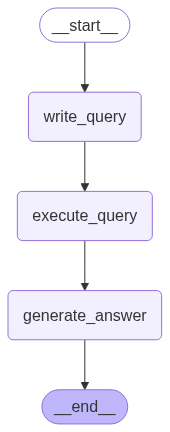

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "What album have the most tracks?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT Album.Title, COUNT(Track.TrackId) AS TrackCount \nFROM Album \nJOIN Track ON Album.AlbumId = Track.AlbumId \nGROUP BY Album.AlbumId \nORDER BY TrackCount DESC \nLIMIT 10;'}}
{'execute_query': {'result': "[('Greatest Hits', 57), ('Minha Historia', 34), ('Unplugged', 30), ('Lost, Season 3', 26), ('Lost, Season 1', 25), ('The Office, Season 3', 25), ('My Way: The Best Of Frank Sinatra [Disc 1]', 24), ('Lost, Season 2', 24), ('Battlestar Galactica (Classic), Season 1', 24), ('Afrociberdelia', 23)]"}}
{'generate_answer': {'answer': 'The album with the most tracks is "Greatest Hits," which has 57 tracks.'}}


In [ ]:
for step in graph.stream(
    {"question": "Give me the top 5 tracks of album has the most tracks?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT Track.Name, Track.AlbumId, COUNT(Track.TrackId) AS TrackCount \nFROM Track \nJOIN Album ON Track.AlbumId = Album.AlbumId \nGROUP BY Track.AlbumId \nORDER BY TrackCount DESC \nLIMIT 1; \n \nSELECT Track.Name \nFROM Track \nWHERE Track.AlbumId = (SELECT AlbumId FROM Album ORDER BY (SELECT COUNT(*) FROM Track WHERE Track.AlbumId = Album.AlbumId) DESC LIMIT 1)\nLIMIT 5;'}}
{'execute_query': {'result': 'Error: (sqlite3.ProgrammingError) You can only execute one statement at a time.\n[SQL: SELECT Track.Name, Track.AlbumId, COUNT(Track.TrackId) AS TrackCount \nFROM Track \nJOIN Album ON Track.AlbumId = Album.AlbumId \nGROUP BY Track.AlbumId \nORDER BY TrackCount DESC \nLIMIT 1; \n \nSELECT Track.Name \nFROM Track \nWHERE Track.AlbumId = (SELECT AlbumId FROM Album ORDER BY (SELECT COUNT(*) FROM Track WHERE Track.AlbumId = Album.AlbumId) DESC LIMIT 1)\nLIMIT 5;]\n(Background on this error at: https://sqlalche.me/e/20/f405)'}}
{'generate_answer': {'answer': "The

### Human-in-the-loop

- Add human action before some sensitive steps, for example, review SQL, execution approval.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

config = {"configurable": {"thread_id": "user001"}}

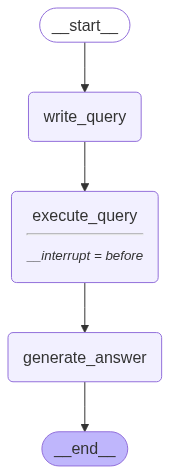

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {
        "question": "Give me the top 5 tracks of album has the most tracks?"
    },
    config=config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # continue the graph
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user")

{'write_query': {'query': 'SELECT Track.Name, Album.Title \nFROM Track \nJOIN Album ON Track.AlbumId = Album.AlbumId \nWHERE Album.AlbumId = (SELECT AlbumId \n                         FROM Track \n                         GROUP BY AlbumId \n                         ORDER BY COUNT(*) DESC \n                         LIMIT 1) \nLIMIT 5;'}}
{'__interrupt__': ()}
Do you want to execute query? (yes/no): yes
{'execute_query': {'result': '[(\'Are You Gonna Go My Way\', \'Greatest Hits\'), (\'Fly Away\', \'Greatest Hits\'), (\'Rock And Roll Is Dead\', \'Greatest Hits\'), (\'Again\', \'Greatest Hits\'), ("It Ain\'t Over \'Til It\'s Over", \'Greatest Hits\')]'}}
{'generate_answer': {'answer': 'The top 5 tracks from the album that has the most tracks are:\n\n1. Are You Gonna Go My Way\n2. Fly Away\n3. Rock And Roll Is Dead\n4. Again\n5. It Ain\'t Over \'Til It\'s Over\n\nThe album title is "Greatest Hits."'}}


#### More techniques

- [Prompting strategies](https://python.langchain.com/docs/how_to/sql_prompting/): Advanced prompt engineering techniques.

- [Query checking](https://python.langchain.com/docs/how_to/sql_query_checking/): Add query validation and error handling.

- [Large databases](https://python.langchain.com/docs/how_to/sql_large_db/): Techniques for working with large databases.

### Agents approach

- Query db as many times as needed to answer the question

- Recover from errors by running query, catching traceback and regenerating

- Based on db'schema and content (no need pre-provided db schema)

Using `SQLDatabaseToolkit` agent

- Create and execute queries

- Check syntax

- Retrieve table descriptions

- ...

In-depth tutorials: [Build a SQL agent](https://langchain-ai.github.io/langgraph/tutorials/sql-agent)

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

In [ ]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c233ab2f910>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c233ab2f910>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c233ab2f910>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [ ]:
system_message_for_agent = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Nevery query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can
query. Do NOT skip this step.

Then you should query the schema of the most relevant tables
""".format(
    dialect="SQLite",
    top_k=5,
)

In [ ]:
from langchain_core.messages import HumanMessageChunk
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message_for_agent)

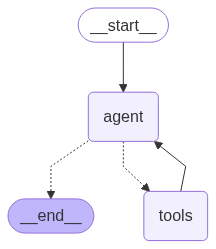

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_ojBis0tWIhXBpdr50vnl306y)
 Call ID: call_ojBis0tWIhXBpdr50vnl306y
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_EGVprCUrlAtGnLYUU1BfqvSt)
 Call ID: call_EGVprCUrlAtGnLYUU1BfqvSt
  Args:
    table_names: Customer
  sql_db_schema (call_lcaIlFBvcXFcprophNbOZDWR)
 Call ID: call_lcaIlFBvcXFcprophNbOZDWR
  Args:
    table_names: Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Invoice" (
	"Inv

In [ ]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_obMJ2OAw5KV6xqV16RRxivCB)
 Call ID: call_obMJ2OAw5KV6xqV16RRxivCB
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_UvmKBDJCAdB0yhRYMWoEbqxr)
 Call ID: call_UvmKBDJCAdB0yhRYMWoEbqxr
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackI

#### Dealing with high-cardinality columns

- If there are columns that contain proper nouns such as addresses, song names or artist. It would be difficult for filter target data if user input a propert noun incorrectly


- We creating a vector store with distinct proper nouns exist in db and have the agent query that vector store each time user includes a proper noun in their question, to find correct spelling for that word.



In [ ]:
import ast
import re

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))

artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

["Monteverdi: L'Orfeo",
 'Dark Side Of The Moon',
 'Acústico MTV [Live]',
 'Slaves And Masters',
 'Purcell: The Fairy Queen']

In [ ]:
artists[:5]

['Creedence Clearwater Revival',
 'Metallica',
 'Santana Feat. The Project G&B',
 'Orchestre Révolutionnaire et Romantique & John Eliot Gardiner',
 'Legião Urbana']

In [ ]:
!pip install -qU langchain-openai

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})
descriptions = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=descriptions,
)

In [ ]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Jagged Little Pill

Angel Dust

Amy Winehouse


In [ ]:
print(retriever_tool.invoke("Vo Minh Duy"))

Minas

Vinicius De Moraes

Duos II

Vinicius, Toquinho & Quarteto Em Cy

Vinícius De Moraes & Baden Powell


In [ ]:
# update agent system message for using new retriever tool
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system_message_for_agent_v2 = f"{system_message_for_agent}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system_message_for_agent_v2)

In [ ]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_yiEcm3kdECwHXyJTd9x6Bii7)
 Call ID: call_yiEcm3kdECwHXyJTd9x6Bii7
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_Dcl5jYT8i1PyY1gTE2Khbbzu)
 Call ID: call_Dcl5jYT8i1PyY1gTE2Khbbzu
  Args:
    table_names: Artist, Album
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	F